In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from einops import rearrange, repeat

from collections import deque

import sys
import copy

from datetime import datetime as dt
import matplotlib.pyplot as plt

# Models

## Transformer

In [12]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d_emb, d_hid, heads):
        super().__init__()
        self.d_hid = d_hid
        self.heads = heads
        self.dim_per_head = self.d_hid // self.heads
        
        self.qkv = nn.Linear(d_emb, self.d_hid * 3, bias = False)
        
        
        self.unifyheads = nn.Linear(self.d_hid, d_emb)
    
    def self_attention(self, q, k, v):
        scores = torch.einsum('...ij,...kj->...ik', q, k) / np.sqrt(self.dim_per_head)
        scores = F.softmax(scores, dim = -1)
        return torch.einsum('...ij,...jk->...ik', scores, v)
    
    def forward(self, x):
        qkv = self.qkv(x)
        q = qkv[..., :self.d_hid]
        k = qkv[..., self.d_hid : self.d_hid * 2]
        v = qkv[..., self.d_hid * 2 :]
            
        q = rearrange(q, '... i (h j) -> ... h i j', h = self.heads)
        k = rearrange(k, '... i (h j) -> ... h i j', h = self.heads)
        v = rearrange(v, '... i (h j) -> ... h i j', h = self.heads)
                
        scores = self.self_attention(q, k, v)
        scores = rearrange(scores, '... h i j -> ... i (h j)').contiguous()
                
        return self.unifyheads(scores)

In [13]:
class GLU(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.out_size = out_size
        self.linear = nn.Linear(in_size, out_size * 2)
    def forward(self, x):
        x = self.linear(x)
        #x = x[..., : self.out_size] * x[..., self.out_size :].sigmoid()
        x = torch.einsum('...i, ...i->...i', [x[..., : self.out_size], x[..., self.out_size :].sigmoid()])

In [14]:
class Encoder_layer(nn.Module):
    def __init__(self, d_emb, d_hid, hidden_mult, heads, enc_drop):
        super().__init__()
        self.dropout = nn.Dropout(enc_drop)
        
        self.mha = Multi_Head_Attention(d_emb, d_hid, heads)
        self.norm_1 = nn.LayerNorm(d_emb)
        self.ff = nn.Sequential(
            nn.Linear(d_emb, hidden_mult * d_emb),
            #nn.ReLU(),
            #nn.GELU(),
            nn.LeakyReLU(),
            nn.Linear(hidden_mult * d_emb, d_emb)
        )
        #self.ff = GLU(d_emb, d_emb)
        
        self.norm_2 = nn.LayerNorm(d_emb)
        
    def forward(self, x):
        attended = self.mha(x)
        x = attended + x
        x = self.dropout(x)
        x = self.norm_1(x)
        fed_for = self.ff(x)
        x = fed_for + x
        x = self.dropout(x)
        x = self.norm_2(x)
        return x

In [15]:
class Transformer(nn.Module):
    def __init__(self, model_hp):
        super().__init__()
        self.epochs = 0
        self.losses = []
        
        d_emb, seq_length, hidden_mult, order, enc_drop, d_toks, m_toks = model_hp
        
        self.sr_d_emb = np.sqrt(d_emb)
        
        self.dice_emb = nn.Embedding(6, d_emb)
        self.table_emb = nn.Embedding(31, d_emb)
        
        self.cls_toks = d_toks + m_toks * 2
        self.pe = nn.Parameter(torch.rand(seq_length + self.cls_toks, d_emb))
        self.cls_token = nn.Parameter(torch.rand(self.cls_toks, d_emb))
        
        self.encoder = nn.ModuleList()
        for d_hid, heads in order:
            self.encoder.append(Encoder_layer(d_emb, d_hid, hidden_mult, heads, enc_drop))
        
        self.out = nn.Linear(self.cls_toks * d_emb, 52)
                
        self.weights_init()
        
        
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight, gain = nn.init.calculate_gain('relu'))
                #m.bias.data.fill_(0.01)
         
    def forward(self, x):
        d = x[..., :2]
        t = x[..., 2:] + 15
        d = self.dice_emb(d)
        t = self.table_emb(t)
        #x = rearrange(x, '... (s e) -> ... s e', e = self.d_emb)
        cls_toks = repeat(self.cls_token, 's e -> b s e', b = d.size(0))
        x = torch.cat((cls_toks, t, d), dim = 1)
        x = x * self.sr_d_emb + self.pe #[:x.size(1)]
        for enc in self.encoder:
            x = enc(x)
        #out = self.out(rearrange(x, 'i j k -> i (j k)'))
        x = x[:, :self.cls_toks]
        x = rearrange(x, '... s e -> ... (s e)')
        x = self.out(x)
        d = x[:, :2]
        m1 = x[:, 2 : -25]
        m2 = x[:, -25:]
        #return F.softmax(d, dim = -1), F.softmax(m1, dim = -1), F.softmax(m2, dim = -1)
        return d, m1, m2

# MCTS

In [16]:
class Node():
    def __init__(self):
        self.home_cells = {6 : 18, 5 : 19, 4 : 20, 3 : 21, 2 : 22, 1 : 23}
        self.phase = 0  # 0/1/2 -- game/house/done
        self.flag_first_turn = True
        self.table = np.zeros(24, dtype = int)
        self.table[0] = 15
        self.table[12] = -15
        self.mine = {0}
        self.his = {12}
        
        self.player = 1
        self.prior = 0
        self.visit_count = 0
        self.value_sum = 0
        self.children = []
    
    def check_phase(self):
        if self.phase == 0:
            condition = lambda x : x > 17
            if all(condition(x) for x in self.mine):
                self.phase = 1
        elif self.phase == 1:
            if not self.mine:
                self.phase = 2
    
    def get_legal_actions(self, die, flag_head):
        die += 1
        legal_actions = np.zeros(25)
        if self.phase == 1:
            flag_out = True
            tempo_actions = []
            for p in range(6, die - 1, -1):
                if self.home_cells[p] in self.mine:
                    tempo_actions.append(p)
                    flag_out = False
            if flag_out:
                legal_actions[list(self.mine)] = 1
            else:
                for p in tempo_actions:
                    if (self.home_cells[p] + die > 23) or (self.home_cells[p - die] not in self.his):
                        legal_actions[self.home_cells[p]] = 1
        elif self.phase == 0:
            for p in self.mine:
                destination = p + die
                if (destination < 24) and (destination not in self.his):
                    if destination < 12 and destination not in self.mine:
                        new_mine = self.mine | {destination}
                        if not self.check_mars(new_mine):
                            legal_actions[p] = 1
                    else:
                        legal_actions[p] = 1
            if flag_head and not self.flag_first_turn:
                legal_actions[0] = 0
        return legal_actions.astype(bool)
    
    def check_mars(self, new_mine):
        n = 6
        mars_end = 0
        for i in range(7):
            if all(j in new_mine for j in range(i, i + n)):
                mars_end = i + n
        if mars_end:
            for i in range(mars_end, 12):
                if i in self.his:
                    return False
            return True
        return False

    def update_table(self, action, die, me = True):
        die += 1
        if me:
            destination = action + die
            self.table[action] -= 1
            if self.table[action] < 1:
                self.mine.remove(action)
            if destination < 24:
                self.table[destination] += 1
                self.mine.add(destination)
        else:
            destination = action + die
            action = (action + 12) % 24
            self.table[action] += 1
            if self.table[action] > -1:
                self.his.remove(action)
            if destination < 24:
                destination = (destination + 12) % 24
                self.table[destination] -= 1
                self.his.add(destination)
    
    def copy(self):
        new_node = Node()
        new_node.phase = self.phase
        new_node.table = self.table
        new_node.mine = self.mine
        new_node.his = self.his
        return new_node
    
    def expand(self, agent):
        pd, pm1, pm2 = action_probs
        for d, d1 in enumerate(dice):
            d2 = dice[d ^ 1]
            mask_1 = self.get_legal_actions(d1, False)
            if mask_1.sum() > 0:
                moves_1 = actions_index[mask_1]
            else:
                moves_1 = [24]
            for m1 in moves_1:
                tempo_node = self.copy()
                tempo_node.update_table(m1, d1, True)
                mask_2 = tempo_node.get_legal_actions(d2, m1 == 0)
                if mask_2.sum() > 0:
                    moves_2 = actions_index[mask_2]
                else:
                    moves_2 = [24]
                for m2 in moves_2:
                    final_node = tempo_node.copy()
                    final_node.prior = pd[d] * pm1[m1] * pm2[m2]
                    self.children.append(final_node)
    
    def expanded(self):
        return len(self.children)
    
    def UCB(self, global_visits, c):
        av = self.value_sum / self.visit_count
        return av + c * self.prior * np.sqrt(np.log(global_visits) / (1 + self.visit_count))
    
    def select_child(self, global_visits, c):
        max_value = -np.inf
        selected_child = None
        for child in self.children:
            value = child.UCB(global_visits, c)
            if value > max_value:
                max_value = value
                selected_child = child
        return selected_child
    
    def flip_the_table(self):
        
    
    def print_table(self):
        row_format = '{:>6}' * 13
        print(row_format.format('', *self.table[11::-1]))
        print(row_format.format('', *self.table[12:]))

In [ ]:
class MCTS:
    def __init__(self, node, c):
        self.root = node.copy()
        self.c = c  #UCB constant
    
    def run(self, iterations, agent):
        action_probs = agent.calculate()
        self.root.expand(action_probs, agent.dice)
        for i in range(iterations):
            node = self.root
            search_path = [node]
            while node.expanded():
                node = node.select_child(i, c)
                search_path.append[node]
        
    def rollout(node_me, node_him):
        while True:
            dice = roll()
            

In [26]:
ml = [1, 5, -3]

In [27]:
nl = -ml

TypeError: bad operand type for unary -: 'list'

# Agents

In [17]:
class Agent():
    def __init__(self, model, model_hp, device):
        super().__init__()
        #self.node = Node()
        self.q_network = model(model_hp).to(device)
        #self.dice = None
        self.flag_winner = False
        
        self.epsilon = 0.5
        self.memory_size = 2**13
        self.buffer_size = 2**7
        self.rep_memory = deque(maxlen = self.memory_size) #[2 dice,  24 table cells], size 26
        self.act_memory = deque(maxlen = self.memory_size) #[die, move1, move1]
        self.rew_memory = deque(maxlen = self.memory_size)
        
        self.games_played = 0
        self.loss = []
    
    def refresh(self, reset = False):
        #self.node = Node()
        #self.node.flag_first_turn = True
        #self.dice = None
        self.flag_winner = False
        if reset:
            self.rep_memory = []
            self.act_memory = []
            self.rew_memory = []
    
    def update_rep_memory(self, dice, table):
        self.rep_memory.append(np.concatenate((dice , table)))
    def update_act_memory(self, d, m1, m2):
        self.act_memory.append([d, m1, m2])
    def update_rew_memory(self):
        self.rew_memory.append(-1)
    
    def memory_not_full(self):
        return len(self.rew_memory) != self.memory_size
        
    def num_parameters(self):
        n = sum(p.numel() for p in self.q_network.parameters() if p.requires_grad)
        print('number of parameters:', n)
        
    def calculate(self, dice, table):
        x = np.concatenate((dice , table))
        x = torch.LongTensor(x).to(device)
        x = x.unsqueeze(0)
        self.q_network.eval()
        with torch.no_grad():
            d, m1, m2 = self.q_network(x)
        return d.detach().cpu()[0], m1.detach().cpu()[0], m2.detach().cpu()[0]
    
    def print_replay_memory(self, num_turns):
        row_format = '{:>6}' * 13
        for i in range(len(self.rep_memory) - num_turns , len(self.rep_memory)):
            print(row_format.format('', *self.rep_memory[i][13:1:-1]))
            print(row_format.format('', *self.rep_memory[i][14:]))
            print(self.rep_memory[i][:2] + 1)
            print(self.act_memory[i])
            print(self.rew_memory[i])
            print()
    
    def train_the_agent(self, epochs, gamma, update_interval):
        self.q_network.train()
        #self.t_network.eval()
        for epoch in range(epochs):
            indices = np.random.choice(range(self.memory_size - 1), self.buffer_size, replace = False)
            # Retrieve corresponding elements using the sampled indices
            states = [self.rep_memory[i] for i in indices]
            states = torch.tensor(np.vstack(states)).to(device)
            next_states = [self.rep_memory[i + 1] for i in indices]
            next_states = torch.tensor(np.vstack(next_states)).to(device)
            actions = [self.act_memory[i] for i in indices]
            actions = torch.tensor(actions).to(device)
            rewards = [self.rew_memory[i] for i in indices]
            rewards = torch.tensor(rewards).to(device)
            done = torch.eq(rewards, -1).int().to(device)

            d, m1, m2 = self.q_network(states)
            q_d_values = d.gather(1, actions[:, 0].unsqueeze(1)).squeeze(1)
            q_m1_values = m1.gather(1, actions[:, 1].unsqueeze(1)).squeeze(1)
            q_m2_values = m2.gather(1, actions[:, 1].unsqueeze(1)).squeeze(1)

            d, m1, m2 = self.t_network(next_states)
            t_d_values = rewards + done * gamma * d.max(1)[0]
            t_m1_values = rewards + done * gamma * m1.max(1)[0]
            t_m2_values = rewards + done * gamma * m2.max(1)[0]

            loss = self.criterion(torch.cat((q_d_values, q_m1_values, q_m2_values)), 
                                  torch.cat((t_d_values, t_m1_values, t_m2_values)))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.loss.append(loss.item())

            if epoch % update_interval == 0:
                self.t_network.load_state_dict(self.q_network.state_dict())

In [18]:
class Agent_h():
    def __init__(self):
        super().__init__()
        self.node = Node()
        self.dice = None
        self.dice_index = np.arange(2)
        self.actions_index = np.arange(25)
        self.flag_winner = False
        
        self.memory_size = 2**13
        
        self.rep_memory = deque(maxlen = self.memory_size) #[2 dice,  24 table cells], size 26
        self.act_memory = deque(maxlen = self.memory_size) #[die, move1, move1]
        self.rew_memory = deque(maxlen = self.memory_size)
        self.games_played = 0
    
    def refresh(self, reset = False):
        self.node = Node()
        self.node.flag_first_turn = True
        self.dice = None
        self.flag_winner = False
        if reset:
            self.rep_memory = []
            self.act_memory = []
            self.rew_memory = []
    
    def roll(self):
        self.dice = list(np.random.randint(6, size = 2))
    
    def update_rep_memory(self):
        self.rep_memory.append(np.concatenate((self.dice , self.node.table)))
    def update_act_memory(self, d, m1, m2):
        self.act_memory.append([d, m1, m2])
    def update_rew_memory(self):
        self.rew_memory.append(-1)
    
    def memory_not_full(self):
        return len(self.rew_memory) != self.memory_size
        
    def print_replay_memory(self, num_turns):
        row_format = '{:>6}' * 13
        for i in range(len(self.rep_memory) - num_turns , len(self.rep_memory)):
            print(row_format.format('', *self.rep_memory[i][13:1:-1]))
            print(row_format.format('', *self.rep_memory[i][14:]))
            print(self.rep_memory[i][:2] + 1)
            print(self.act_memory[i])
            print(self.rew_memory[i])
            print()

# Functinos

In [ ]:
def roll():
    return list(np.random.randint(6, size = 2))

In [19]:
def turn(agent, ag, flag_print = False):
    epsilon = agent.epsilon
    if flag_print:
        agent.node.print_table()
        epsilon = None
    if agent.node.phase != 2:
        agent.dice = roll() # roll the dice
        if flag_print:
            print(' ' * 36, agent.dice[0] + 1, agent.dice[1] + 1)
        else:
            agent.update_rep_memory()
        d, m1, m2 = agent.calculate()
        if epsilon is not None:
            if np.random.random() < agent.epsilon:
                d = np.random.choice(dice_index)
            else:
                d = F.softmax(d, dim = -1).numpy()
                d = np.random.choice(dice_index, p = d)
        else:
            d = F.softmax(d, dim = -1).numpy()
            d = np.argmax(d)
        d1 = agent.dice[d]
        d2 = agent.dice[d ^ 1]
        flag_head = False
        mask = agent.node.get_legal_actions(d1, flag_head)
        if mask.sum() > 0:
            if epsilon is not None:
                if np.random.random() < agent.epsilon:
                    m1 = np.random.choice(actions_index[mask])
                else:
                    m1 = F.softmax(m1[mask], dim = -1).numpy()
                    m1 = np.random.choice(actions_index[mask], p = m1)
            else:
                m1 = F.softmax(m1[mask], dim = -1).numpy()
                m1 = np.argmax(m1)
                m1 = actions_index[mask][m1]
            agent.node.update_table(m1, d1, True)
            ag.node.update_table(m1, d1, False)
            agent.node.check_phase()
            if flag_print:
                print('1st', m1, d1 + 1)
                agent.node.print_table()
        else:
            m1 = 24
            if flag_print:
                print('no legal moves')
        if m1 == 0:
            flag_head = True
        mask = agent.node.get_legal_actions(d2, flag_head)
        if mask.sum() > 0:
            if epsilon is not None:
                if np.random.random() < agent.epsilon:
                    m2 = np.random.choice(actions_index[mask])
                else:
                    m2 = F.softmax(m2[mask], dim = -1).numpy()
                    m2 = np.random.choice(actions_index[mask], p = m2)
            else:
                m2 = F.softmax(m2[mask], dim = -1).numpy()
                m2 = np.argmax(m2)
                m2 = actions_index[mask][m2]
            agent.node.update_table(m2, d2, True)
            ag.node.update_table(m2, d2, False)
            agent.node.check_phase()
            if flag_print:
                print('2nd', m2, d2 + 1)
                agent.node.print_table()
        else:
            m2 = 24
            if flag_print:
                print('no legal moves')
        if not flag_print:
            agent.update_act_memory(d, m1, m2)
            agent.update_rew_memory()
        if agent.node.phase == 2:
            #agent.flag_done = True
            agent.flag_winner = True
        if agent.node.flag_first_turn:
            agent.node.flag_first_turn = False

In [20]:
def session(ag_1, ag_2):
    ag_1.refresh(reset = False)
    ag_2.refresh(reset = False)
    while True:
        turn(ag_1, ag_2)
        if ag_1.flag_winner:
            ag_1.rew_memory[-1] = 20
            ag_2.rew_memory[-1] = -20
            break
        turn(ag_2, ag_1)
        if ag_2.flag_winner:
            ag_2.rew_memory[-1] = 20
            ag_1.rew_memory[-1] = -20
            break
    ag_1.games_played += 1
    ag_2.games_played += 1

In [21]:
def fill_the_replay_memory(ag_1, ag_2):
    start_time = dt.now()
    while ag_1.memory_not_full() or ag_2.memory_not_full():
        session(ag_1, ag_2)
        session(ag_2, ag_1)
        if ag_1.games_played % 10 == 0:
            elapsed = dt.now() - start_time
            secs = elapsed.seconds
            printout = '\rsessions: %d, ag_1: %d, ag_2: %d, %02d:%02d:%02d:%02d'
            sys.stdout.write(printout % (ag_1.games_played, len(ag_1.rew_memory), len(ag_2.rew_memory), 
                                         elapsed.days, secs // 3600, secs // 60 % 60, secs % 60))
            sys.stdout.flush()
    sys.stdout.write('\n')

In [22]:
def collect_and_train(ag_1, ag_2, num_sessions, train_interval, epochs, gamma, update_interval):
    start_time = dt.now()
    ns = num_sessions // 2
    ti = train_interval // 2
    for i in range(ns):
        if i % ti == 0:
            ag_1.train_the_agent(epochs, gamma, update_interval)
            ag_2.train_the_agent(epochs, gamma, update_interval)
        session(ag_1, ag_2)
        session(ag_2, ag_1)
        
        elapsed = dt.now() - start_time
        ratio = i / ns
        secs = elapsed.seconds
        printout = '\r[%-16s] %d%%, sessions: %d, %02d:%02d:%02d:%02d'
        sys.stdout.write(printout % ('='*round(16 * ratio), round(100 * ratio), i * 2, 
                                     elapsed.days, secs // 3600, secs // 60 % 60, secs % 60))
        sys.stdout.flush()
    sys.stdout.write('\n')
    print('Done')

In [23]:
def turn_a(agent, ag):
    print(' ' * 36, 'Agent')
    agent.node.print_table()
    if agent.node.phase != 2:
        agent.roll() # roll the dice
        print(' ' * 36, agent.dice[0] + 1, agent.dice[1] + 1)
        d, m1, m2 = agent.calculate()
        d = F.softmax(d, dim = -1).numpy()
        d = np.argmax(d)
        d1 = agent.dice.pop(d)
        d2 = agent.dice[0]
        flag_head = False
        mask = agent.node.get_legal_actions(d1, flag_head)
        if mask.sum() > 0:
            m1 = F.softmax(m1[mask], dim = -1).numpy()
            m1 = np.argmax(m1)
            m1 = actions_index[mask][m1]
            agent.node.update_table(m1, d1, True)
            ag.node.update_table(m1, d1, False)
            agent.node.check_phase()
            print('1st', m1, d1 + 1)
            agent.node.print_table()
        else:
            m1 = 24
            print('no legal moves')
        if agent.node.flag_first_turn:
            agent.node.flag_first_turn = False
        elif m1 == 0:
            flag_head = True
        mask = agent.node.get_legal_actions(d2, flag_head)
        if mask.sum() > 0:
            m2 = F.softmax(m2[mask], dim = -1).numpy()
            m2 = np.argmax(m2)
            m2 = actions_index[mask][m2]
            agent.node.update_table(m2, d2, True)
            ag.node.update_table(m2, d2, False)
            agent.node.check_phase()
            print('2nd', m2, d2 + 1)
            agent.node.print_table()
        else:
            m2 = 24
            print('no legal moves')
        if agent.node.phase == 2:
            agent.flag_winner = True
    print('\n')

In [24]:
def turn_h(agent, ag):
    print(' ' * 36, 'Human')
    agent.node.print_table()
    if agent.node.phase != 2:
        agent.roll() # roll the dice
        print(' ' * 36, agent.dice[0] + 1, agent.dice[1] + 1)
        d = int(input('Pick your die: '))
        d1 = agent.dice.pop(d)
        d2 = agent.dice[0]
        flag_head = False
        mask = agent.node.get_legal_actions(d1, flag_head)
        if mask.sum() > 0:
            while True:
                m1 = int(input('Move your piece: '))
                if mask[m1]:
                    agent.node.update_table(m1, d1, True)
                    ag.node.update_table(m1, d1, False)
                    agent.node.check_phase()
                    print('1st', m1, d1 + 1)
                    agent.node.print_table()
                    break
        else:
            print('no legal moves')
        if agent.node.flag_first_turn:
            agent.node.flag_first_turn = False
        elif m1 == 0:
            flag_head = True
        mask = agent.node.get_legal_actions(d2, flag_head)
        if mask.sum() > 0:
            while True:
                m2 = int(input('Move your piece: '))
                if mask[m2]:
                    agent.node.update_table(m2, d2, True)
                    ag.node.update_table(m2, d2, False)
                    agent.node.check_phase()
                    print('2nd', m2, d2 + 1)
                    agent.node.print_table()
                    break
        else:
            print('no legal moves')
        if agent.node.phase == 2:
            agent.flag_winner = True
    print('\n')

In [25]:
def session_h(ag, hum, h_first = True):
    ag.refresh(reset = False)
    hum.refresh(reset = False)
    if h_first:
        while True:
            turn_h(hum, ag)
            if hum.flag_winner:
                ag.rew_memory[-1] = -20
                break
            turn_a(ag, hum)
            if ag.flag_winner:
                ag.rew_memory[-1] = 20
                break
    else:
        while True:
            turn_a(ag, hum)
            if ag.flag_winner:
                ag.rew_memory[-1] = 20
                break
            turn_h(hum, ag)
            if hum.flag_winner:
                ag.rew_memory[-1] = -20
                break

# Create agents

In [26]:
my_path = 'data/nardw/'

In [27]:
cuda_core = 0
if torch.cuda.is_available():
    torch.cuda.set_device(cuda_core)
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


In [28]:
#device = torch.device('cpu')

In [29]:
dice_index = np.arange(2)
actions_index = np.arange(25)

d_emb = 8
seq_length = 26
hidden_mult = 2
order = [(128, 8), (128, 8), 
         (64, 4), (64, 4), 
         (64, 2), (64, 2), 
         (32, 1), (32, 1)]
#order = [(32, 4), (32, 4), (32, 2), (32, 2), (32, 1), (32, 1)]

enc_drop = 0 # 0.05  # 0.005
d_toks = 1
m_toks = 2

lr = 0.0001

In [30]:
model1_hp = d_emb, seq_length, hidden_mult, order, enc_drop, d_toks, m_toks
model = Transformer
# optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
# criterion = nn.HuberLoss()

In [31]:
flag_load = False

In [32]:
if flag_load:
    ag_1 = torch.load(my_path + 'ag_1_20230525.pth')
    ag_2 = torch.load(my_path + 'ag_2_20230525.pth')
else:
    ag_1 = Agent(model, model1_hp, device)
    ag_1.optimizer = torch.optim.AdamW(ag_1.q_network.parameters(), lr = lr)
    ag_1.criterion = nn.MSELoss()
    ag_2 = Agent(model, model1_hp, device)
    ag_2.optimizer = torch.optim.AdamW(ag_2.q_network.parameters(), lr = lr)
    ag_2.criterion = nn.MSELoss()

In [33]:
print('num of parameters:', sum(p.numel() for p in ag_1.q_network.parameters() if p.requires_grad))

num of parameters: 23708


In [35]:
# start
fill_the_replay_memory(ag_1, ag_2)

sessions: 140, ag_1: 7887, ag_2: 7885, 00:00:01:32


In [390]:
# ag_1.epsilon = 0
# ag_2.epsilon = 0

In [485]:
print(ag_1.epsilon, ag_2.epsilon)

0 0


In [405]:
num_sessions = 4000
train_interval = 100
epochs = 2**7
gamma = 0.95
update_interval = 32

In [406]:
collect_and_train(ag_1, ag_2, num_sessions, train_interval, epochs, gamma, update_interval)

[================] 100%, sessions: 39998, 00:09:07:35
Done


In [34]:
flag_save = False

In [408]:
if flag_save:
    torch.save(ag_1, my_path + 'ag_1_20230525.pth')
    torch.save(ag_2, my_path + 'ag_2_20230525.pth')

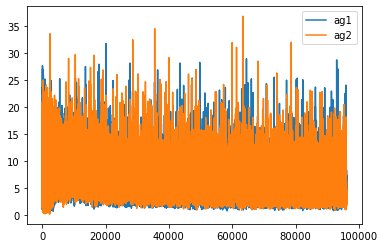

In [409]:
plt.plot(ag_1.loss, label = 'ag1')
plt.plot(ag_2.loss, label = 'ag2')
plt.legend()
plt.show()

In [413]:
# plt.plot(ag_2.loss[-1000:])
# plt.show()

# test session

In [414]:
ag_1.refresh(reset = False)
ag_2.refresh(reset = False)

In [479]:
print('agent 1')
turn(ag_1, ag_2, flag_print = True)
print('\nagent 2')
turn(ag_2, ag_1, flag_print = True)

agent 1
           0     0     0     0     0     0     0     0     0     0     0     0
           0     0     0     0     0     0     0     0     0     0     0     0

agent 2
           0     0     0     0     0     0     0     0     0     0     0     0
           0     0     0     0     0     0     0     0     0     0     0     0


# H Session

In [403]:
hum = Agent_h()

In [ ]:
session_h(ag_1, hum, h_first = True)

# WORKS

In [482]:
0.9**40

0.014780882941434608

In [488]:
d = F.softmax(d, dim = -1).numpy()      
        m1 = F.softmax(m1, dim = -1).numpy()
        m2 = F.softmax(m2, dim = -1).numpy()

In [201]:
#ag_1.num_parameters()

In [183]:
# ag_1.epsilon = 0
# ag_2.epsilon = 0

In [153]:
# ag_1.refresh(reset = False)
# ag_2.refresh(reset = False)

In [36]:
d, m1, m2 = ag_1.calculate()

In [39]:
d = d - d.min()
d

tensor([0.0000, 0.6603])

In [ ]:
size = sys.getsizeof()

In [19]:
class Mine:
    def __init__(self):
        self.var = 0
    
    def create(self):
        child = copy.copy(self)
        child.var = 4
        return child

In [20]:
first = Mine()

In [21]:
first.var

0

In [22]:
second = first.create()

In [23]:
second.var

4

In [24]:
first.var

0

# OLD